# Optimization

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

## Define Model Curves

### Pruning vs Accuracy

In [3]:
def get_accuracy(p):
    #6th order polynomial coefficients
    coeffs = [85.28, -10.35, -28.44, -49.40]
    
    acc = sum(c * p**i for i, c in enumerate(coeffs))

    return max(acc, 0)

### Pruning vs Model Size

In [4]:
def get_size(p):
    coeffs = [496.7, -706.2, 276.9, 4.020]
    
    return sum(c * p**i for i, c in enumerate(coeffs))

### Pruning vs Inference Time

In [5]:
def get_time(p):
    b0 = 0.06386
    b1 = -0.06386
    
    return (b0 + b1 * p)*10

### Plot Curves

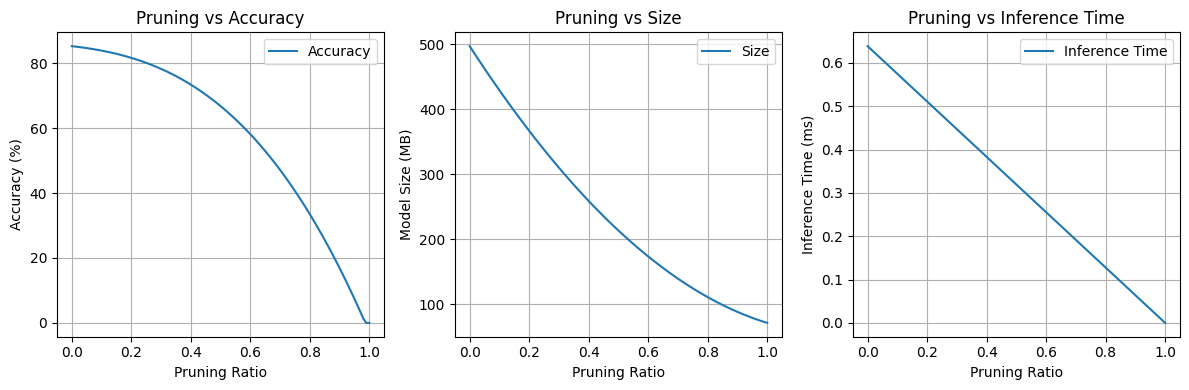

In [6]:
p = np.linspace(0, 1, 100)
sizes = get_size(p)
accuracies = [get_accuracy(p) for p in p]
times = get_time(p)

plt.style.use('default')
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(p, accuracies, label='Accuracy')
plt.xlabel('Pruning Ratio')
plt.ylabel('Accuracy (%)')
plt.title('Pruning vs Accuracy')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(p, sizes, label='Size')
plt.xlabel('Pruning Ratio')
plt.ylabel('Model Size (MB)')
plt.title('Pruning vs Size')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(p, times, label='Inference Time')
plt.xlabel('Pruning Ratio')
plt.ylabel('Inference Time (ms)')
plt.title('Pruning vs Inference Time')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

## Rewards

### Accuracy Rewards

In [7]:
def get_accuracy_reward(curr_accuracy, min_accuracy, sigma_right=4, sigma_left=2):
    diff = curr_accuracy - min_accuracy
    if 0<=diff<=1e-2:
        return (np.exp(- (diff**2) / (10 * sigma_left**2)) * 100)
    else:
        return 1*(np.exp(- (abs(diff)**1.5) / (2 * sigma_right**2)) * 100)

### Inference Time Reward

In [8]:
def get_comp_time_reward(current_comp_time, sigma=0.8):
    return np.exp(- (current_comp_time**2) / (2 * sigma**2))*10

### Model Size Reward

In [9]:
def get_model_size_reward(current_model_size, max_model_size, sigma_left=2):
    diff = current_model_size - max_model_size
    if current_model_size > max_model_size:
        return np.exp(- ((diff)**2) / (10 * sigma_left**2))*99*0.5
    if current_model_size == max_model_size:
        return 99*(0.5)
    else:
        return (99+(current_model_size/max_model_size))*0.5

### Better Pruning Reward

In [10]:
def more_acc_less_size(accuracy, min_accuracy, size, max_model_size):
    if accuracy >= min_accuracy and size <= max_model_size:
        return ((accuracy-min_accuracy)*2) + (max_model_size-size)/2
    return 0

### Final Reward

In [11]:
def get_reward(p, min_accuracy=80.0, max_model_size=350.0, x=10, y=1, z=1) -> float:
    accuracy = get_accuracy(p)
    time = get_time(p)
    size = get_size(p)
    
    acc_reward = np.array(get_accuracy_reward(accuracy, min_accuracy))
    time_reward = np.array(get_comp_time_reward(time))
    size_reward = np.array(get_model_size_reward(size, max_model_size))
    better_reward = more_acc_less_size(accuracy, min_accuracy, size, max_model_size)
    global counts_of_calulating_rewards
    # counts_of_calulating_rewards += 1 # type: ignore
    
    x, y, z = x/(x+y+z), y/(x+y+z), z/(x+y+z)
    
    return (x*acc_reward + y*time_reward + z*size_reward + better_reward + p/2)

## Importance Values

In [12]:
i_org = np.array([0.03044561, 0.02201545, 0.12376647, 0.09755174, 0.04860051,
       0.00832497, 0.03501421, 0.00934147, 0.05674529, 0.15345743,
       0.237974  , 0.17676284])
i = i_org.copy()

## Params

In [13]:
MAX_MODEL_SIZES = [0]*12
GLOBAL_MIN_ACCURACY = 0.0

In [14]:
def init():
    global MAX_MODEL_SIZES, GLOBAL_MIN_ACCURACY
    MAX_MODEL_SIZES = [100.0] * 12

    for j in range(12):
        MAX_MODEL_SIZES[j] = MAX_MODEL_SIZES[j] * np.random.uniform(1.0, 5.0)

    GLOBAL_MIN_ACCURACY = 10 * np.random.uniform(5, 8.2)

    print("\n" + "="*60)
    print(f"MAX_MODEL_SIZES: {np.round(MAX_MODEL_SIZES, 2)}")
    print(f"GLOBAL_MIN_ACCURACY: {GLOBAL_MIN_ACCURACY:.2f}%")
    print("="*60)

## Main Optimization

### Problem Def

In [15]:
class MultiViewProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=12,
            n_obj=12,
            xl=np.zeros(12),
            xu=np.ones(12)
        )

    def _evaluate(self, X, out, *args, **kwargs):
        pop_size, _ = X.shape
        F = np.zeros((pop_size, 12))

        for j in range(12):
            ps = X[:, j]
            vals = np.zeros(pop_size)
            for k, p in enumerate(ps):
                # Use global min accuracy for consistency
                r = get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j])
                weighted_r = r * i[j]
                vals[k] = -weighted_r  # minimize negative reward
            F[:, j] = vals

        out["F"] = F

class SingleObjectiveProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=12,
            n_obj=1,
            xl=np.zeros(12),
            xu=np.ones(12)
        )

    def _evaluate(self, X, out, *args, **kwargs):
        pop_size, _ = X.shape
        F = np.zeros((pop_size, 1))

        for k in range(pop_size):
            p_vec = X[k, :]
            total_reward = 0
            penalty = 0
            
            weighted_acc = 0
            for j, p in enumerate(p_vec):
                acc = get_accuracy(p)
                size = get_size(p)
                weighted_acc += acc * i[j]
                
                # Apply penalty for size violations
                if size > MAX_MODEL_SIZES[j]:
                    penalty += (size - MAX_MODEL_SIZES[j]) ** 2 * 100  # Increased penalty
                
                r = get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j])
                total_reward += r * i[j]

            # Strong penalty if weighted accuracy below global min accuracy
            if weighted_acc < GLOBAL_MIN_ACCURACY:
                penalty += (GLOBAL_MIN_ACCURACY - weighted_acc) ** 2 * 10000  # Much stronger penalty
            
            F[k, 0] = -(total_reward - penalty)

        out["F"] = F

### Check if feasible

In [16]:
def is_feasible_corrected(p_vec):
    accs = np.array([get_accuracy(p) for p in p_vec])
    sizes = np.array([get_size(p) for p in p_vec])
    weighted_acc = np.sum(accs * i)
    
    # Check global accuracy constraint
    if weighted_acc < GLOBAL_MIN_ACCURACY:
        return False, accs, sizes
    
    # Check size constraints
    if np.any(sizes > MAX_MODEL_SIZES):
        return False, accs, sizes
    
    return True, accs, sizes

### Optimize with relaxed contraints

In [17]:
def optimize_with_relaxed_constraints(min_acc, max_sizes):
    # sourcery skip: low-code-quality
    
    class RelaxedSingleObjectiveProblem(Problem):
        def __init__(self):
            super().__init__(
                n_var=12,
                n_obj=1,
                xl=np.zeros(12),
                xu=np.ones(12)
            )

        def _evaluate(self, X, out, *args, **kwargs):
            pop_size, _ = X.shape
            F = np.zeros((pop_size, 1))

            for k in range(pop_size):
                p_vec = X[k, :]
                total_reward = 0
                penalty = 0
                
                weighted_acc = 0
                for j, p in enumerate(p_vec):
                    acc = get_accuracy(p)
                    size = get_size(p)
                    weighted_acc += acc * i[j]
                    
                    # Apply penalty for size violations
                    if size > max_sizes[j]:
                        penalty += (size - max_sizes[j]) ** 2 * 100
                    
                    r = get_reward(p, min_acc, max_sizes[j])
                    total_reward += r * i[j]

                # Penalty if weighted accuracy below relaxed min accuracy
                if weighted_acc < min_acc:
                    penalty += (min_acc - weighted_acc) ** 2 * 5000
                
                F[k, 0] = -(total_reward - penalty)

            out["F"] = F
    
    # Run optimization with relaxed constraints
    problem = RelaxedSingleObjectiveProblem()
    algorithm = GA(pop_size=200)
    
    res = minimize(
        problem,
        algorithm,
        termination=('n_gen', 500),
        verbose=False
    )
    
    best_p_vec = res.X
    accs = np.array([get_accuracy(p) for p in best_p_vec]) # type: ignore
    sizes = np.array([get_size(p) for p in best_p_vec]) # type: ignore
    weighted_acc = np.sum(accs * i)
    
    # Check against relaxed constraints
    acc_feasible = weighted_acc >= min_acc
    size_feasible = np.all(sizes <= max_sizes)
    
    print("\n✦ RELAXED OPTIMIZATION RESULT:")
    print("p values:         ", np.round(best_p_vec, 3)) # type: ignore
    print("view accuracies %:", np.round(accs, 2))
    print("weighted acc %:   ", np.round(weighted_acc, 2))
    print("model sizes:      ", np.round(sizes, 1))
    print("relaxed max sizes:", np.round(max_sizes, 1))
    print("original max sizes:", np.round(MAX_MODEL_SIZES, 1))
    
    if acc_feasible and size_feasible:
        print("FEASIBLE with relaxed constraints!")
        total_r = sum(get_reward(p, min_acc, max_sizes[j]) * i[j] for j, p in enumerate(best_p_vec)) # type: ignore
        print("total reward:     ", np.round(total_r, 2))
        return best_p_vec, accs, sizes, weighted_acc, total_r
    else:
        print("Still infeasible even with relaxed constraints")
        
        # Show violations
        if not acc_feasible:
            print(f"Accuracy violation: {weighted_acc:.2f}% < {min_acc:.2f}%")
        
        if not size_feasible:
            violations = [(j, size, max_sizes[j]) for j, size in enumerate(sizes) if size > max_sizes[j]]
            print(f"Size violations: {len(violations)}")
            for j, size, max_size in violations[:5]:  # Show first 5
                print(f"  View {j+1}: {size:.1f} > {max_size:.1f}")
        
        return best_p_vec, accs, sizes, weighted_acc, None

### Relax Contraints

In [18]:
def relax_constraints_progressively():
    """Progressively relax constraints to find feasible solutions"""
    print("\n" + "="*60)
    print("PROGRESSIVE CONSTRAINT RELAXATION")
    print("="*60)

    relaxation_scenarios = [
        {"acc_relax": 0, "size_relax": 1.0, "desc": "Original constraints"},
        {"acc_relax": 2, "size_relax": 1.05, "desc": "Relax accuracy by 2%, size by 5%"},
        {"acc_relax": 5, "size_relax": 1.1, "desc": "Relax accuracy by 5%, size by 10%"},
        {"acc_relax": 8, "size_relax": 1.15, "desc": "Relax accuracy by 8%, size by 15%"},
        {"acc_relax": 10, "size_relax": 1.2, "desc": "Relax accuracy by 10%, size by 20%"},
    ]

    for scenario in relaxation_scenarios:
        print(f"\n--- {scenario['desc']} ---")

        # Temporarily adjust constraints
        relaxed_min_acc = GLOBAL_MIN_ACCURACY - scenario['acc_relax']
        relaxed_max_sizes = [size * scenario['size_relax'] for size in MAX_MODEL_SIZES]

        print(f"Target accuracy: {relaxed_min_acc:.1f}%")
        print(f"Max sizes: {np.round(relaxed_max_sizes, 1)}")

        # Test feasibility with relaxed constraints
        feasible_count = 0
        best_solution = None
        best_weighted_acc = 0

        for _ in range(500):
            p_vec = np.random.beta(2, 8, 12)
            accs = np.array([get_accuracy(p) for p in p_vec])
            sizes = np.array([get_size(p) for p in p_vec])
            weighted_acc = np.sum(accs * i)

            # Check relaxed constraints
            acc_feasible = weighted_acc >= relaxed_min_acc
            size_feasible = np.all(sizes <= relaxed_max_sizes)

            if acc_feasible and size_feasible:
                feasible_count += 1
                if weighted_acc > best_weighted_acc:
                    best_weighted_acc = weighted_acc
                    best_solution = (p_vec, accs, sizes, weighted_acc)

        print(f"Feasible solutions found: {feasible_count}/500 ({feasible_count/5:.1f}%)")

        if feasible_count > 0:
            print(f"Best weighted accuracy found: {best_weighted_acc:.2f}%")

            # If we found feasible solutions, run optimization with relaxed constraints
            if feasible_count >= 10:  # If reasonably feasible
                print("Running optimization with relaxed constraints...")
                return optimize_with_relaxed_constraints(relaxed_min_acc, relaxed_max_sizes)
        else:
            print("No feasible solutions found with these constraints.")

    print("\nEven with maximum relaxation, no feasible solutions found.")
    print("Constraints may be fundamentally incompatible.")
    return None

### Multi Objective Pruning

In [19]:
def optimize_pruning():  # sourcery skip: low-code-quality
    print("Running multi-objective optimization (NSGA-II)...")
    problem = MultiViewProblem()
    algorithm = NSGA2(pop_size=500)  # Increased population size

    res = minimize(
        problem,
        algorithm,
        termination=('n_gen', 1000),  # Increased generations
        verbose=False
    )

    pareto_ps = res.X

    feasible = []
    for p_vec in pareto_ps: # type: ignore
        valid, accs, sizes = is_feasible_corrected(p_vec)
        if valid:
            feasible.append((p_vec, accs, sizes))

    if feasible:
        best = None
        best_reward = -np.inf
        for p_vec, accs, sizes in feasible:
            total_r = sum(get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j]) * i[j]
                          for j, p in enumerate(p_vec))
            if total_r > best_reward:
                best_reward = total_r
                best = (p_vec, accs, sizes, total_r)

        p_vec, accs, sizes, total_r = best
        weighted_acc = np.sum(accs * i)

        print("\n✦ FEASIBLE solution found with NSGA-II:")
        print("i values:        ", np.round(i, 3))
        print("p values:         ", np.round(p_vec, 3))
        print("view accuracies %:", np.round(accs, 2))
        print("weighted acc %:   ", np.round(weighted_acc, 2))
        print("model sizes:      ", np.round(sizes, 1))
        print("max sizes:        ", np.round(MAX_MODEL_SIZES, 1))
        print("total reward:     ", np.round(total_r, 2))

        return p_vec, accs, sizes, weighted_acc, total_r

    else:
        print("\nNo feasible solution found with NSGA-II. Trying single-objective optimization...")
        single_problem = SingleObjectiveProblem()
        single_algorithm = GA(pop_size=200)  # Increased population size

        single_res = minimize(
            single_problem,
            single_algorithm,
            termination=('n_gen', 1000),  # Increased generations
            verbose=False
        )

        best_p_vec = single_res.X
        valid, accs, sizes = is_feasible_corrected(best_p_vec)

        accs = np.array([get_accuracy(p) for p in best_p_vec])
        sizes = np.array([get_size(p) for p in best_p_vec])
        weighted_acc = np.sum(accs * i)

        if valid:
            total_r = sum(get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j]) * i[j]
                          for j, p in enumerate(best_p_vec))

            print("\n✦ FEASIBLE solution found with single-objective GA:")
            print("p values:         ", np.round(best_p_vec, 3))
            print("view accuracies %:", np.round(accs, 2))
            print("weighted acc %:   ", np.round(weighted_acc, 2))
            print("model sizes:      ", np.round(sizes, 1))
            print("max sizes:        ", np.round(MAX_MODEL_SIZES, 1))
            print("total reward:     ", np.round(total_r, 2))
            return best_p_vec, accs, sizes, weighted_acc, total_r
        else:
            print("\n✦ Best compromise solution (may violate some constraints):")
            print("p values:         ", np.round(best_p_vec, 3))
            print("view accuracies %:", np.round(accs, 2))
            print("weighted acc %:   ", np.round(weighted_acc, 2))
            print("model sizes:      ", np.round(sizes, 1))
            print("max sizes:        ", np.round(MAX_MODEL_SIZES, 1))

            # Check constraint violations
            if weighted_acc < GLOBAL_MIN_ACCURACY:
                print(f"\nGlobal accuracy violation: {weighted_acc:.2f}% < {GLOBAL_MIN_ACCURACY}%")

            if size_violations := [
                (j, size, MAX_MODEL_SIZES[j])
                for j, size in enumerate(sizes)
                if size > MAX_MODEL_SIZES[j]
            ]:
                print("\nSize violations:")
                for j, size, max_size in size_violations:
                    print(f"  View {j+1}: {size:.1f} > {max_size}")

            print("\n" + "="*60)
            print("STARTING PROGRESSIVE CONSTRAINT RELAXATION...")
            print("="*60)

            # Try progressive relaxation
            relaxation_result = relax_constraints_progressively()
            if relaxation_result is not None:
                return relaxation_result

            return best_p_vec, accs, sizes, weighted_acc, None

### Find a Feasible Starting Point

In [20]:
def find_feasible_starting_point():
    """Find a feasible starting point by working backwards from constraints"""
    print("Searching for feasible starting point...")
    
    # Start with p values that give high accuracy but might violate size constraints
    best_p = None
    best_weighted_acc = 0
    
    for _ in range(1000):
        # Generate random p values, biased towards lower pruning (higher accuracy)
        p_vec = np.random.beta(2, 8, 12)  # Biased towards lower values
        
        accs = np.array([get_accuracy(p) for p in p_vec])
        sizes = np.array([get_size(p) for p in p_vec])
        weighted_acc = np.sum(accs * i)
        
        # Check if this meets the global accuracy constraint
        if weighted_acc >= GLOBAL_MIN_ACCURACY:
            # Check size constraints
            if np.all(sizes <= MAX_MODEL_SIZES):
                print(f"Found feasible starting point! Weighted accuracy: {weighted_acc:.2f}%")
                return p_vec, accs, sizes, weighted_acc
            else:
                # Track best accuracy even if size constraints are violated
                if weighted_acc > best_weighted_acc:
                    best_weighted_acc = weighted_acc
                    best_p = p_vec
    
    if best_p is not None:
        accs = np.array([get_accuracy(p) for p in best_p])
        sizes = np.array([get_size(p) for p in best_p])
        print(f"Best found: Weighted accuracy: {best_weighted_acc:.2f}% (meets global min)")
        return best_p, accs, sizes, best_weighted_acc
    else:
        print("No feasible starting point found - constraints may be too tight")
        return None, None, None, None

### Redistribute Accuracy Loss Between Views

In [21]:
def redistribute_accuracy_loss(p_vec, violating_views, target_sizes, i, GLOBAL_MIN_ACCURACY):
    # sourcery skip: low-code-quality
    new_p_vec = p_vec.copy()

    # Calculate current weighted accuracy
    current_accs = np.array([get_accuracy(p) for p in p_vec])
    _ = np.sum(current_accs * i)

    # Calculate required pruning for violating views to meet size constraints
    total_accuracy_loss = 0

    for view_idx in violating_views:
        target_size = target_sizes[view_idx]

        # Find pruning amount that gives the target size
        # Use binary search to find p that gives size <= target_size
        p_low, p_high = 0.0, 1.0
        best_p = p_vec[view_idx]

        for _ in range(50):  # Binary search iterations
            p_mid = (p_low + p_high) / 2
            size_mid = get_size(p_mid)

            if size_mid <= target_size:
                best_p = p_mid
                p_high = p_mid
            else:
                p_low = p_mid

            if abs(p_high - p_low) < 1e-6:
                break

        # Calculate accuracy loss for this view
        old_acc = get_accuracy(p_vec[view_idx])
        new_acc = get_accuracy(best_p)
        acc_loss = old_acc - new_acc

        # Weight the accuracy loss by importance
        weighted_acc_loss = acc_loss * i[view_idx]
        total_accuracy_loss += weighted_acc_loss

        # Update pruning for this view
        new_p_vec[view_idx] = best_p

        print(f"View {view_idx+1}: Adjusted pruning from {p_vec[view_idx]:.4f} to {best_p:.4f}")
        print(f"  Size: {get_size(p_vec[view_idx]):.1f} → {get_size(best_p):.1f} (max: {target_size:.1f})")
        print(f"  Accuracy: {old_acc:.2f}% → {new_acc:.2f}% (loss: {acc_loss:.2f}%)")
        print(f"  Weighted loss: {weighted_acc_loss:.2f}%")

    print(f"\nTotal weighted accuracy loss: {total_accuracy_loss:.2f}%")

    # Redistribute the accuracy loss among non-violating views
    non_violating_views = [i for i in range(12) if i not in violating_views]

    if not non_violating_views:
        print("All views violate size constraints - cannot redistribute")
        return new_p_vec, False

    # Calculate how much we need to recover in weighted accuracy
    new_weighted_acc = np.sum([get_accuracy(new_p_vec[j]) * i[j] for j in range(12)])
    accuracy_deficit = GLOBAL_MIN_ACCURACY - new_weighted_acc

    print(f"New weighted accuracy after size adjustments: {new_weighted_acc:.2f}%")
    print(f"Required global minimum: {GLOBAL_MIN_ACCURACY:.2f}%")
    print(f"Accuracy deficit to recover: {accuracy_deficit:.2f}%")

    if accuracy_deficit <= 0:
        print("No redistribution needed - global constraint already satisfied")
        return new_p_vec, True

    # Try to recover the deficit by reducing pruning in non-violating views
    print(f"\nRedistributing {accuracy_deficit:.2f}% accuracy deficit among {len(non_violating_views)} views...")

    # Sort non-violating views by their ability to improve (lower current pruning = more room to improve)
    view_flexibility = [(j, new_p_vec[j]) for j in non_violating_views]
    view_flexibility.sort(key=lambda x: x[1])  # Sort by current pruning (ascending)

    remaining_deficit = accuracy_deficit

    for view_idx, current_p in view_flexibility:
        if remaining_deficit <= 0:
            break

        # Calculate how much this view can contribute
        # Try reducing pruning to improve accuracy
        min_p = 0.0
        max_improvement_p = current_p

        if max_improvement_p >= min_p:
            # Calculate potential accuracy improvement
            current_acc = get_accuracy(current_p)
            improved_acc = get_accuracy(max_improvement_p)
            potential_improvement = (improved_acc - current_acc) * i[view_idx]

            # Take what we need or what's available, whichever is smaller
            if potential_improvement > 0:
                # Calculate exact pruning needed for this view's contribution
                needed_acc_improvement = min(remaining_deficit / i[view_idx], improved_acc - current_acc)

                # Find pruning that gives this accuracy improvement
                target_acc = current_acc + needed_acc_improvement

                # Binary search for pruning that gives target accuracy
                p_low, p_high = 0, current_p
                best_p = current_p

                for _ in range(50):
                    p_mid = (p_low + p_high) / 2
                    acc_mid = get_accuracy(p_mid)

                    if acc_mid >= target_acc:
                        best_p = p_mid
                        p_high = p_mid
                    else:
                        p_low = p_mid

                    if abs(p_high - p_low) < 1e-6:
                        break

                # Check if this adjustment violates size constraint
                new_size = get_size(best_p)
                if new_size <= MAX_MODEL_SIZES[view_idx]:
                    actual_improvement = (get_accuracy(best_p) - current_acc) * i[view_idx]
                    new_p_vec[view_idx] = best_p
                    remaining_deficit -= actual_improvement

                    print(f"View {view_idx+1}: Reduced pruning from {current_p:.4f} to {best_p:.4f}")
                    print(f"  Accuracy: {current_acc:.2f}% → {get_accuracy(best_p):.2f}%")
                    print(f"  Weighted contribution: {actual_improvement:.2f}%")
                    print(f"  Size: {get_size(current_p):.1f} → {new_size:.1f} (max: {MAX_MODEL_SIZES[view_idx]:.1f})")
                else:
                    print(f"View {view_idx+1}: Cannot reduce pruning further without violating size constraint")

    # Check final result
    final_weighted_acc = np.sum([get_accuracy(new_p_vec[j]) * i[j] for j in range(12)])
    final_success = final_weighted_acc >= GLOBAL_MIN_ACCURACY

    print(f"\n{'='*50}")
    print("REDISTRIBUTION RESULT:")
    print(f"Final weighted accuracy: {final_weighted_acc:.2f}%")
    print(f"Global minimum required: {GLOBAL_MIN_ACCURACY:.2f}%")
    print(f"Success: {"Y" if final_success else 'N'}")

    if not final_success:
        print(f"Remaining deficit: {GLOBAL_MIN_ACCURACY - final_weighted_acc:.2f}%")

    return new_p_vec, final_success

### Handle Size Violations

In [22]:
def handle_size_violations(p_vec, i, global_min_accuracy, MAX_MODEL_SIZES):
    print("\n" + "="*60)
    print("HANDLING SIZE CONSTRAINT VIOLATIONS")
    print("="*60)

    # Identify violating views
    current_sizes = np.array([get_size(p) for p in p_vec])
    violating_views = [i for i, size in enumerate(current_sizes) if size > MAX_MODEL_SIZES[i]]

    if not violating_views:
        print("No size violations detected.")
        accs = np.array([get_accuracy(p) for p in p_vec])
        weighted_acc = np.sum(accs * i)
        return p_vec, True, {
            'weighted_accuracy': weighted_acc,
            'view_accuracies': accs,
            'view_sizes': current_sizes,
            'violations': []
        }

    print(f"Found {len(violating_views)} views violating size constraints:")
    for view_idx in violating_views:
        print(f"  View {view_idx+1}: {current_sizes[view_idx]:.1f} > {MAX_MODEL_SIZES[view_idx]:.1f}")

    # Redistribute accuracy loss
    adjusted_p_vec, success = redistribute_accuracy_loss(
        p_vec, violating_views, MAX_MODEL_SIZES, i, global_min_accuracy
    )

    # Calculate final metrics
    final_accs = np.array([get_accuracy(p) for p in adjusted_p_vec])
    final_sizes = np.array([get_size(p) for p in adjusted_p_vec])
    final_weighted_acc = np.sum(final_accs * i)

    remaining_violations = [
        {
            'view': j + 1,
            'size': final_sizes[j],
            'max_size': MAX_MODEL_SIZES[j],
            'violation': final_sizes[j] - MAX_MODEL_SIZES[j],
        }
        for j in range(12)
        if final_sizes[j] > MAX_MODEL_SIZES[j]
    ]
    final_metrics = {
        'weighted_accuracy': final_weighted_acc,
        'view_accuracies': final_accs,
        'view_sizes': final_sizes,
        'violations': remaining_violations,
        'global_constraint_met': final_weighted_acc >= global_min_accuracy
    }

    return adjusted_p_vec, success and not remaining_violations, final_metrics

### Check if redistribution was successful

In [23]:
def successful_redist(adjusted_p_vec, i, metrics, total_r):
    # Calculate new total reward
    new_total_r = sum(get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j]) * i[j]
                     for j, p in enumerate(adjusted_p_vec))

    print("\nSUCCESSFUL REDISTRIBUTION:")
    print("Adjusted p values:    ", np.round(adjusted_p_vec, 3))
    print("View accuracies %:    ", np.round(metrics['view_accuracies'], 4))
    print("Weighted accuracy %:  ", np.round(metrics['weighted_accuracy'], 4))
    print("Model sizes:          ", np.round(metrics['view_sizes'], 2))
    print("Max sizes:            ", np.round(MAX_MODEL_SIZES, 2))
    print("New total reward:     ", np.round(new_total_r, 2))
    print("Original total reward:", np.round(total_r, 2))

    return adjusted_p_vec, metrics['view_accuracies'], metrics['view_sizes'], metrics['weighted_accuracy'], new_total_r

### Optimize with Redist

In [24]:
def optimize_pruning_with_redistribution():
    print("Running enhanced optimization with redistribution...")

    # First try standard optimization
    result = optimize_pruning()

    if result is None:
        print("Standard optimization failed. Trying redistribution approach...")
        return None

    p_vec, accs, sizes, weighted_acc, total_r = result

    # Fix: Use proper variable names to avoid conflicts
    size_violations = [view_idx for view_idx, size in enumerate(sizes) if size > MAX_MODEL_SIZES[view_idx]] # type: ignore

    if not size_violations:
        print("No size violations - solution is already feasible!")
        return result

    print(f"\nDetected {len(size_violations)} size violations. Applying redistribution...")
    
    # Debug: Print the actual violations
    print("Size violations detected:")
    for view_idx in size_violations:
        print(f"  View {view_idx+1}: {sizes[view_idx]:.1f} > {MAX_MODEL_SIZES[view_idx]:.1f}") # type: ignore

    # Apply redistribution
    adjusted_p_vec, success, metrics = handle_size_violations(
        p_vec, i, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES # type: ignore
    )

    if success:
        return successful_redist(adjusted_p_vec, i, metrics, total_r)
    
    print("Redistribution failed - returning original solution with violations")
    return result

### Params

In [25]:
init()


MAX_MODEL_SIZES: [121.11 233.83 138.06 365.94 248.04 391.92 387.98 117.34 404.8  221.69
 113.19 338.11]
GLOBAL_MIN_ACCURACY: 57.20%


### Main Loop

In [26]:
print("Testing redistribution approach...")
print("="*70)
print("Global minimum accuracy:", GLOBAL_MIN_ACCURACY)
print("Max model sizes:", np.round(MAX_MODEL_SIZES, 2))
print("="*70)

test_result = find_feasible_starting_point()
if test_result[0] is not None:
    print("Running optimization with redistribution...")
    final_result = optimize_pruning_with_redistribution()
    
    if final_result is not None:
        print("\nFINAL OPTIMIZED SOLUTION WITH REDISTRIBUTION COMPLETE")
        print("Adjusted p values:        ", np.round(final_result[0], 3))
        print("View accuracies %:        ", np.round(final_result[1], 2))
        print("Weighted accuracy %:      ", np.round(final_result[3], 2))
        print("Required global accuracy: ", GLOBAL_MIN_ACCURACY)
        print("Model sizes:              ", np.round(final_result[2], 1))
        print("Max sizes:                ", np.round(MAX_MODEL_SIZES, 1))
        print("Total reward:             ", np.round(final_result[4], 2)) if final_result[4] is not None else print("No total reward calculated.")
        
        print(f"{'View':<6} {'Size':<10} {'Max Size':<12} {'Accuracy (%)':<15} {'Importance':<10}, {'Prune':<10}")
        print("-" * 70)

        views_violated = []
        
        for view in range(12):
            size = final_result[2][view]
            max_size = MAX_MODEL_SIZES[view]
            acc = final_result[1][view]
            importance = i[view]
            prune = final_result[0][view]
            if np.round(size, 1) > np.round(max_size, 1):
                views_violated.append(view + 1)
            print(f"{view+1:<6}, {size:<10.1f}, {max_size:<12.1f}, {acc:<15.2f}, {importance*100:<12.2f}, {prune:<10.3f}")
        print("\n" + "="*70)
        print("Final Weighted Accuracy: ", np.round(final_result[3], 1), "Required:", np.round(GLOBAL_MIN_ACCURACY, 1))
        print("Views violating size constraints:", views_violated if views_violated else "None")
        if np.round(final_result[3], 1) >= np.round(GLOBAL_MIN_ACCURACY, 1):
            print("Solution meets global accuracy requirement!")
        else:
            print("Solution does NOT meet global accuracy requirement.")
        
else:
    print("Constraints appear too tight even for redistribution approach.")

Testing redistribution approach...
Global minimum accuracy: 57.20055789244857
Max model sizes: [121.11 233.83 138.06 365.94 248.04 391.92 387.98 117.34 404.8  221.69
 113.19 338.11]
Searching for feasible starting point...
Best found: Weighted accuracy: 83.98% (meets global min)
Running optimization with redistribution...
Running enhanced optimization with redistribution...
Running multi-objective optimization (NSGA-II)...

No feasible solution found with NSGA-II. Trying single-objective optimization...

✦ Best compromise solution (may violate some constraints):
p values:          [0.762 0.596 0.704 0.347 0.588 0.338 0.331 0.776 0.357 0.589 0.792 0.366]
view accuracies %: [39.01 58.57 46.61 76.18 59.36 76.63 76.95 37.04 75.71 59.19 34.77 75.27]
weighted acc %:    57.2
model sizes:       [121.1 175.1 138.1 285.  178.2 289.9 293.4 117.3 280.1 177.5 113.2 275.7]
max sizes:         [121.1 233.8 138.1 365.9 248.  391.9 388.  117.3 404.8 221.7 113.2 338.1]

Global accuracy violation: 57.20% 

## Optimizing Computation Time

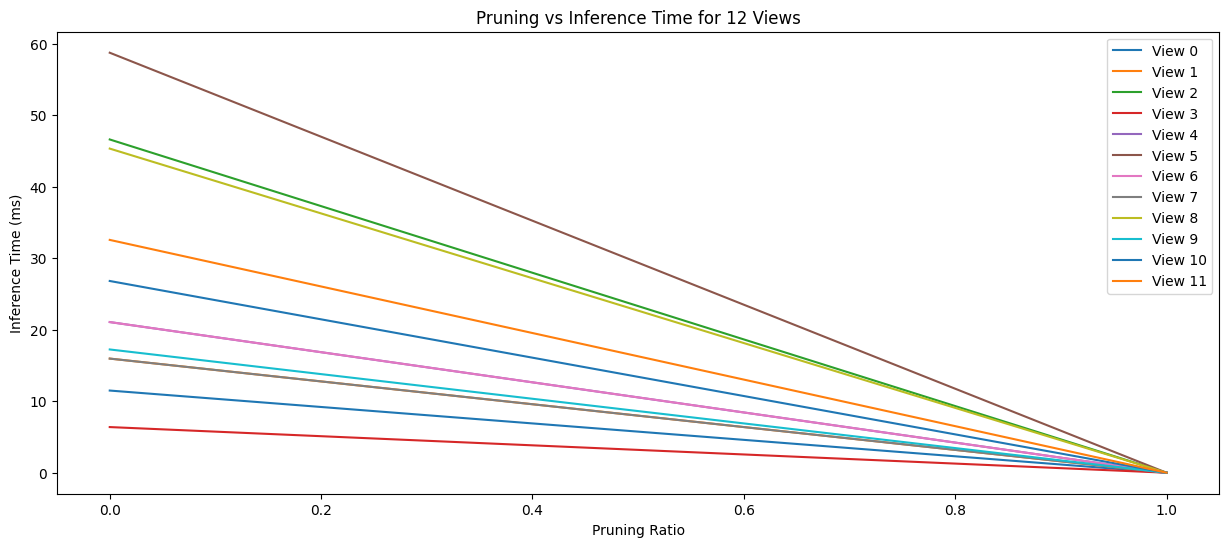

In [160]:
times = {}

plt.figure(figsize=(15, 6))
for v in range(12):
    k = np.random.randint(10, 100)
    t = [(get_time(p)*k) for p in np.linspace(0, 1, 100)]
    plt.plot(np.linspace(0, 1, 100), t, label=f'View {v}')
    times[v] = np.array(t)
    # print(f"View {v+1} inference time: {t[-50]:.2f} ms at p=0.5")

plt.xlabel('Pruning Ratio')
plt.ylabel('Inference Time (ms)')
plt.title('Pruning vs Inference Time for 12 Views')
plt.legend()

--------------------------------------------------------------|
|View   | Inference Time       | p          | Device Perf     |
--------------------------------------------------------------|
|1      | 0.0067               | 0.94       | 0.82            |
|2      | 0.1147               | 0.58       | 0.57            |
|3      | 0.2717               | 0.55       | 0.05            |
|4      | 0.0986               | 0.61       | 0.60            |
|5      | 0.0482               | 0.89       | 0.30            |
|6      | 0.1378               | 0.28       | 0.70            |
|7      | 0.0363               | 0.76       | 0.76            |
|8      | 0.0058               | 0.89       | 0.92            |
|9      | 0.1096               | 0.52       | 0.64            |
|10     | 0.0520               | 0.54       | 0.82            |
|11     | 0.0230               | 0.84       | 0.78            |
|12     | 0.1856               | 0.60       | 0.27            |
----------------------------------------

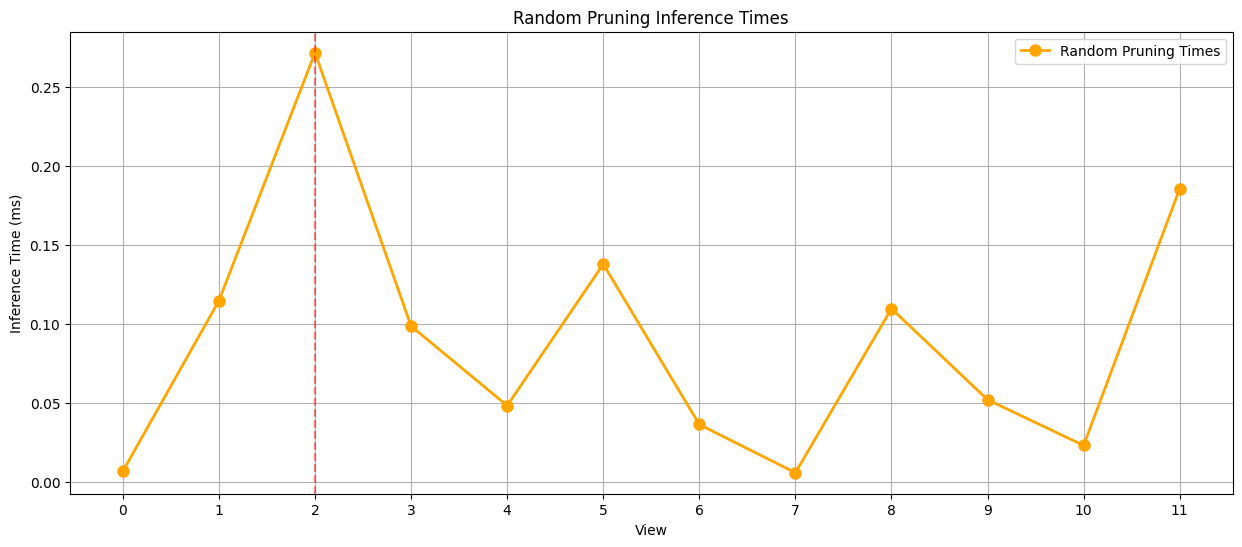

In [154]:
rand_p = np.random.uniform(0.1, 1, 12)
device_perf = np.random.uniform(0, 1, 12)

rand_times: np.ndarray = np.array([get_time(p)-(get_time(p)*device_perf[i]) for i, p in enumerate(rand_p)])

bottleneck = np.max(rand_times)
view_bottleneck = np.argmax(rand_times).item()

print("-" * 62 + "|")
print(f"|{'View':<6} | {'Inference Time':<20} | {'p':<10} | {'Device Perf':<15} |")
print("-" * 62 + "|")

for k in range(12):
    print(f"|{k+1:<6} | {rand_times[k]:<20.4f} | {rand_p[k]:<10.2f} | {device_perf[k]:<15.2f} |")
print("-" * 62 + "|")

print(f"\nBottleneck view: {view_bottleneck+1} with time {bottleneck:.4f} ms at p={rand_p[view_bottleneck]:.2f} with device perf {device_perf[view_bottleneck]:.2f}")

plt.figure(figsize=(15, 6))
plt.plot(range(12), rand_times, 'o-', label='Random Pruning Times', color='orange', linewidth=2, markersize=8)
plt.xticks(range(12))
plt.axvline(view_bottleneck, color='red', linestyle='--', alpha=0.5)
plt.xlabel('View')
plt.ylabel('Inference Time (ms)')
plt.title('Random Pruning Inference Times')
plt.legend()
plt.grid()
plt.show()

In [101]:
rand_times.mean(), rand_times.std(), rand_times.min(), rand_times.max()

(np.float64(0.7677518146756351),
 np.float64(0.24499068103090743),
 np.float64(0.393154402733684),
 np.float64(1.1758339028332538))